In [1]:
import filenistview 
import random
import pickle
import numpy as np
import sys
import torch

import matplotlib.pyplot as plt

In [2]:
nvldata = filenistview.FileHandlerNVL.load("70824A05 NVL cropped.nvl")

FileHandler <class 'filenistview.FileHandlerNVL'>: Load file 70824A05 NVL cropped.nvl
IDL Save file is compressed
 -> expanding to /var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/tmppjslg4r6.sav
--------------------------------------------------
Date: Tue Apr 12 10:37:34 2011
User: Eric
Host: TASKMASTER
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: Win32
IDL Version: 7.1.2
--------------------------------------------------
Successfully read 14 records of which:
 - 2 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 7 are of type HEAP_DATA
 - 1 are of type TIMESTAMP
 - 1 are of type HEAP_HEADER
--------------------------------------------------
Available variables:
 - savestructure [<class 'numpy.recarray'>]
 - saveversion [<class 'numpy.float32'>]
--------------------------------------------------


In [3]:
print(nvldata.shape)

(1, 41, 468, 468)


In [4]:
nvldata = np.asarray(nvldata)

In [5]:
print(nvldata[0,:,0,0])

[4539.401   4489.2144  4434.01    4745.1797  4619.6987  4388.8423
 4434.01    4423.9727  4474.1587  4328.6187  4519.326   4554.4565
 4469.14    4328.6187  4544.4194  4835.5146  4930.868   3450.3455
 1678.7583   644.9078   293.58902  815.5407  2065.1917  3600.9194
 4910.794   4057.6135  2802.9438  2255.8992  2125.415   2050.136
 2311.104   2336.197   2351.253   2446.6064  2306.0852  2235.8247
 2296.048   2451.6252  2255.8992  2120.3965  2035.0801 ]


In [6]:
print(np.min(nvldata))
print(np.max(nvldata))

-2627.2925
32222.508


In [7]:
norm_data = nvldata / np.max(nvldata)
print(norm_data[0,:,0,0])

[0.14087671 0.13931921 0.13760598 0.14726289 0.14336869 0.13620424
 0.13760598 0.13729449 0.13885197 0.13433525 0.14025371 0.14134395
 0.13869622 0.13433525 0.14103246 0.15006636 0.15302558 0.10707874
 0.05209893 0.0200142  0.0091113  0.02530966 0.06409159 0.11175168
 0.1524026  0.12592483 0.08698715 0.07001004 0.06596057 0.06362434
 0.07172328 0.07250202 0.07296927 0.07592849 0.07156753 0.06938705
 0.07125603 0.07608425 0.07001004 0.06580482 0.0631571 ]


In [8]:
# each member of the training dataset has size 41 energies, 468 rows, 468 columns
nvl_modified = np.zeros((41, 468, 468))

for i in range(468):
    for j in range(468):
        nvl_modified[:,i,j] = norm_data[0,:,i,j]

In [9]:
print(nvl_modified[:,420,4])

[0.16532974 0.164551   0.16065729 0.16439526 0.15582907 0.14804162
 0.14087671 0.14554964 0.13324501 0.12888405 0.12296559 0.1159569
 0.10848048 0.09742231 0.09103661 0.08745439 0.07997845 0.06471458
 0.05350067 0.03294135 0.01705498 0.03294135 0.0561484  0.06362434
 0.07359227 0.07966647 0.0804457  0.08309343 0.0865199  0.08356068
 0.08807738 0.08527391 0.08138019 0.08309343 0.08511816 0.08558541
 0.08418367 0.08465092 0.08402792 0.08293768 0.07764173]


In [10]:
print(nvl_modified.shape)

(41, 468, 468)


In [11]:
delta_x = 1 # delta_x is the change in row #
delta_y = 1 # delta_y is the change in column #

# create a set from nvl_modified spanning from (x0, y0) to x0+x_dim, y0+y_dim)
def create_data(x0, y0, x_dim, y_dim):
    new = nvl_modified[:, x0:(x0 + x_dim), y0:(y0 + y_dim)]
    return new
    
# reorganize a grid of len_z-value arrays into a list
def data_flat(x_array):
    len_x = x_array.shape[1]
    len_y = x_array.shape[2]
    len_z = x_array.shape[0]
    new = np.zeros((len_x * len_y, len_z))
    count = 0
    for j in range(len_y):
        for i in range(len_x):
            new[count,:] = x_array[:, i, j]
            count += 1
    
    return new

# create a set from nvl_modified that is shifted by delta_x, delta_y from the input
def create_output(x0, y0, x_dim, y_dim):
    new = create_data(x0 + delta_x, y0 + delta_y, x_dim, y_dim)
    return new

In [12]:
# flattened array with a length of 458 (columns) x 458 (rows) grid points
nvl_flat_feat = data_flat(create_data(0, 0, 458, 458))
print(nvl_flat_feat.shape)
nvl_flat_labels = data_flat(create_output(0, 0, 458, 458))
print(nvl_flat_labels.shape)

(209764, 41)
(209764, 41)


In [13]:
# check that the features and labels align properly
print(nvl_flat_feat[delta_y * 458 + delta_x])
print(nvl_flat_labels[0])

[0.12062937 0.11502241 0.12218685 0.11720289 0.11985062 0.11922763
 0.11704715 0.11782589 0.12296559 0.11798164 0.12421158 0.12935129
 0.13682723 0.135114   0.14243419 0.19663574 0.26547769 0.21610481
 0.09633207 0.03029362 0.00568483 0.01845671 0.05147594 0.12452308
 0.1891598  0.16081303 0.09711082 0.07514975 0.0695428  0.07265777
 0.06642782 0.07374801 0.06798531 0.06596057 0.06082086 0.0570829
 0.06019787 0.05132019 0.05287768 0.05318918 0.05381217]
[0.12062937 0.11502241 0.12218685 0.11720289 0.11985062 0.11922763
 0.11704715 0.11782589 0.12296559 0.11798164 0.12421158 0.12935129
 0.13682723 0.135114   0.14243419 0.19663574 0.26547769 0.21610481
 0.09633207 0.03029362 0.00568483 0.01845671 0.05147594 0.12452308
 0.1891598  0.16081303 0.09711082 0.07514975 0.0695428  0.07265777
 0.06642782 0.07374801 0.06798531 0.06596057 0.06082086 0.0570829
 0.06019787 0.05132019 0.05287768 0.05318918 0.05381217]


In [14]:
# choose some number of random indices to create our features and labels sets
train_size = 20000

# create and store the indices
#ind_list = random.sample(range(209764), train_size)
#pickle.dump(ind_list, open("IndList.pickle", "wb"))

# if training indices already stored in a file, just load them
ind_list = pickle.load(open("IndList.pickle", "rb"))

feat = np.zeros((train_size, 41))
labels = np.zeros((train_size, 41))
for i in range(train_size):
    # e.g., for the 0th training pair, we refer to the 0th index listed in ind_list
    feat[i] = nvl_flat_feat[ind_list[i],:]
    labels[i] = nvl_flat_labels[ind_list[i],:]

In [15]:
print(feat.shape)
print(labels.shape)

(20000, 41)
(20000, 41)


In [16]:
print(ind_list[:10])

[6501, 176642, 128649, 88726, 157166, 78557, 98487, 113019, 85214, 74849]


In [17]:
feat = torch.from_numpy(feat).float()
labels = torch.from_numpy(labels).float()

In [28]:
# define model, optimizer, and loss function
model = torch.nn.Sequential(torch.nn.Linear(41, 150),\
                            torch.nn.Sigmoid(),\
                           torch.nn.Linear(150, 41))

# L2 loss
loss_fn = torch.nn.MSELoss()

In [19]:
#model = pickle.load(open("OneLayer3spot.pickle", "rb"))

In [29]:
lr = 1e-4
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [1]:
for i in range(50000):
    # given (x,y), predict (x+y_pred, y)
    prediction = model(feat)
    
    # calculate loss 
    loss = loss_fn(prediction, labels)
    
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 500 == 0:
        print("Step " + str(i) + ": loss = " + str(loss.data.item()))

# See how the model performs on an arbitrary set of data.

In [78]:
# check the first few training indices 
print(ind_list[:10])

[6501, 176642, 128649, 88726, 157166, 78557, 98487, 113019, 85214, 74849]


In [54]:
# get three random spectra in the dataset
test_size = 3
test_ind_list = random.sample(range(209764), test_size)
print(test_ind_list)

[28452, 128445, 888]


In [64]:
print(888 in ind_list)

False


In [27]:
test_ind = 888
test_feat = torch.from_numpy(nvl_flat_feat[test_ind]).float()
test_labels = torch.from_numpy(nvl_flat_labels[test_ind]).float()

pred_spec = model(test_feat)
real_spec = test_labels

# print(pred_spec)
# print(real_spec)

print(loss_fn(pred_spec, real_spec))

tensor(0.0009, grad_fn=<MseLossBackward>)


In [21]:
print(test_ind in ind_list)

False


# Save the model

In [31]:
pickle.dump(model, open("TwoLayer1down1right.pickle", "wb"))

# Plotting spectra

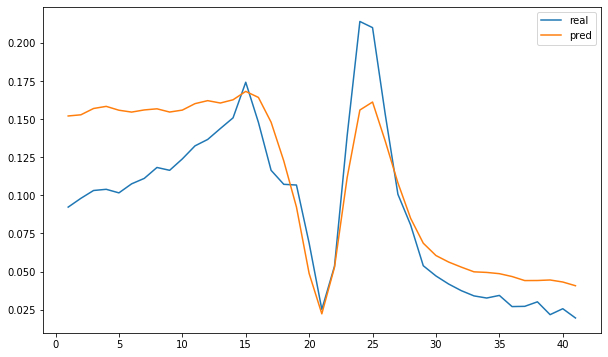

In [66]:
x_axis = list(range(1,42))

fig = plt.figure(figsize=(10,6))

plt.plot(x_axis, real_spec, label = "real")
plt.plot(x_axis, pred_spec.detach(), label = "pred")
plt.legend()

In [51]:
# see what the model's parameters look like
weights = torch.from_numpy(np.zeros(1))
bias = torch.from_numpy(np.zeros(1))

x = 1
for param in model.parameters():
    if x == 2:
        bias = param.data
        #print(param.data)
        #print(param.data.shape)   
        
    if x == 1:
        weights = param.data
        #print(param.data)
        #print(param.data.shape)
        x = 2  
        
print(weights)
print(bias)

tensor([[ 2.8354e-01,  8.4679e-02,  9.9055e-02,  ...,  3.0221e-01,
          6.4399e-03,  2.3511e-02],
        [ 2.4506e-01,  1.4895e-01, -4.1788e-02,  ...,  2.5437e-01,
          1.0731e-01, -3.4343e-02],
        [ 1.8150e-01,  2.1025e-01, -3.3466e-02,  ...,  1.2265e-01,
         -2.2504e-05,  5.7476e-02],
        ...,
        [ 1.2443e-02,  1.5136e-02,  8.2232e-03,  ...,  8.3819e-02,
          8.6346e-02,  1.5688e-01],
        [ 1.9999e-02, -1.5088e-02,  2.0894e-02,  ...,  1.3711e-01,
          1.1727e-01,  1.7736e-01],
        [ 5.2772e-02, -1.8095e-02, -5.5261e-02,  ...,  1.3567e-01,
          2.2492e-01,  1.8733e-01]])
tensor([0.2600, 0.2583, 0.2571, 0.2566, 0.2552, 0.2510, 0.2456, 0.2448, 0.2415,
        0.2345, 0.2267, 0.2198, 0.2112, 0.1996, 0.1813, 0.1586, 0.1408, 0.1207,
        0.0938, 0.0527, 0.0243, 0.0398, 0.0708, 0.0853, 0.0875, 0.0873, 0.0856,
        0.0853, 0.0825, 0.0801, 0.0790, 0.0785, 0.0759, 0.0728, 0.0707, 0.0711,
        0.0693, 0.0672, 0.0671, 0.0670, 0.0651])

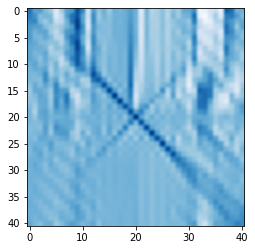

In [52]:
# a = np.random.random((16, 16))
# plt.imshow(a, cmap='hot', interpolation='nearest')
# plt.show()
plt.imshow(weights.numpy(), cmap='Blues', interpolation='hermite')
plt.show()